cd /hdd_mnt/onurcan/onurk && jupyter notebook --ip 0.0.0.0 --port=1999

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import sys
sys.path.append("..")

from dataloaders.dataloader_v1 import get_loader
import torch
from wcmatch.pathlib import Path
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from matplotlib import pyplot as plt
from einops import rearrange, repeat
import cv2
import numpy as np
import random

hdd_mnt = "mnt_hdd" # mnt_hdd cvat, hdd_mnt amax
root = f"/{hdd_mnt}/onurcan/onurk/datasets/"
# root = "/raid/KaraGAG/Fujinon_Trains/onurcan_dataset/"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# batch_size = 13*2 # 12 cvat, 24 amax
batch_size = 15

stage = "train"
dataloader = get_loader("noise_amplitude_with_multiple_hio_dataset", stage, root, batch_size, alpha=3)
stage = "val"
val_dataloader = get_loader("noise_amplitude_with_multiple_hio_dataset", stage, root, batch_size, alpha=3)
stage = "test"
test_dataloader = get_loader("noise_amplitude_with_multiple_hio_dataset", stage, root, batch_size, alpha=3)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# selected_indices_dataloader = list(range(30)) + [random.randrange(len(dataloader.dataset)) for _ in range(30)] # 57000
# dataloader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataloader.dataset, selected_indices_dataloader), batch_size=batch_size, shuffle=True)

In [4]:
len(dataloader)

2942

In [5]:
import torch
from utils.utils import zero_padding_twice, fft2d, ifft2d
from utils.algorithms import apply_image_constraint_hio
from models.denoisers import get_denoiser

class End2End(torch.nn.Module):
    def __init__(
        self,
        device: torch.device,
        total_iterations: int = 12,
        total_dc_iterations: int = 5,
        denoiser_architecture: str = "FBPConvNet",
    ):
        super().__init__()

        self.denoiser = get_denoiser(denoiser_architecture)().to(device)

        self.lam = torch.nn.Parameter(
            torch.logspace(-0.64, -0.10, total_iterations).to(device)
        )  # 1....0.125 from the thesis, lam should be [0,1]
        
        self.total_iterations = total_iterations
        self.total_dc_iterations = total_dc_iterations
        self.beta = 0.9
        self.alpha = 3.0
        self.etas = torch.linspace(1.0, 1.0, total_iterations + 1).to(device) * self.alpha

    def rand_timestep_for_training(self, batch_size):
        # we could also create timesteps btw 0 1 indep of total_iterations
        a = 2.0
        delta_mask = (torch.rand(size=(batch_size,)) <= a / (1 + a)).float()
        return ((1 - delta_mask) * torch.randint(low=1, high=self.total_iterations + 1, size=(batch_size,)) + delta_mask * self.total_iterations).int()
    
    def ideal_corrupt(self, x_0, x_T, timestep):
        """
            x_0: ground truth image
            x_T: initial image (hio output)
            timestep: unnormalized timestep -> [1, total_iterations]
        """
        timestep_ = timestep.view(-1, 1, 1, 1).to(x_0.device)
        normalized_timestep = timestep_ / self.total_iterations
        return (1 - normalized_timestep) * x_0 + normalized_timestep * x_T + torch.randn_like(x_0) * normalized_timestep * self.etas[timestep_]
        
    def forward(self, x_, timestep, amplitude, support, hio_output, train_mode=False):
        # z_ = self.denoiser(x_ / 255.0, timestep) * 255.0
        # z_ = torch.clamp(z_, min=0.0, max=255.0)
        # timestep_tensor = timestep.view(-1, 1, 1, 1)
        # x_ = z_ * (timestep_tensor <= 1) + self.dc(z_, amplitude, timestep, support) * (timestep_tensor > 1)
        # return x_
        timestep_tensor = timestep.view(-1, 1, 1, 1)
        x_concat = torch.cat([x_, hio_output], dim=1)
        after_denoiser = self.denoiser(x_concat / 255.0, timestep) * 255.0
        after_dc = torch.clamp(self.dc(after_denoiser, amplitude, timestep, support), min=0.0, max=255.0)
        
        return torch.cat([after_dc, after_denoiser], dim=1) if train_mode else after_dc
    
    def step_corrupt(self, x_0_estimate, prev_step, timestep):
        timestep_ = timestep.view(-1, 1, 1, 1)
        delta = 1 / self.total_iterations
        normalized_timestep = timestep_ * delta
        return delta / normalized_timestep * x_0_estimate + (1 - delta / normalized_timestep) * prev_step + (normalized_timestep - delta) * torch.randn_like(x_0_estimate) * (self.etas[timestep_ - 1]**2 - self.etas[timestep_]**2).sqrt()
        
    def infer(self, x_T, amplitude, support, x_T_mean):
        x_ = x_T_mean + torch.randn_like(x_T_mean) * self.etas[-1]
        for i in range(self.total_iterations, 0, -1):
            timestep = torch.tensor([i]).to(x_T.device).repeat(x_T.shape[0])
            x_ = self.step_corrupt(self.forward(x_, timestep, amplitude, support, x_T), x_, timestep)
        return x_

    def dc(self, z, b, i, support):
        i = i.view(-1, 1, 1, 1) - 1
        z_k = zero_padding_twice(z)
        z_0 = z_k

        y_new = self.lam[i] * b + (1 - self.lam[i]) * fft2d(z_0).abs()

        for _ in range(self.total_dc_iterations):
            Fz = fft2d(z_k)
            # x_kprime = ifft2d(torch.polar(self.lam[i] * b + (1 - self.lam[i]) * Fz.abs(), Fz.angle())).real
            # x_kprime = ifft2d(torch.polar(self.lam[i] * b, Fz.angle())).real + (1 - self.lam[i]) * z_0
            # z_k = apply_image_constraint_hio(x_kprime, z_k, support, beta=self.beta)
            
            x_kprime = ifft2d(torch.polar(y_new, Fz.angle())).real
            z_k = apply_image_constraint_hio(x_kprime, z_k, support, beta=self.beta)

        return crop_center_half(z_k)

In [6]:
total_iterations = 32#4,8,32
denoiser_architecture = "UNet2D11Channels"

end2end_model = End2End(device=device, total_iterations=total_iterations, denoiser_architecture=denoiser_architecture)
loss = torch.nn.MSELoss()
train_loss = torch.nn.MSELoss()
# optimizer = torch.optim.AdamW(end2end_model.parameters(), lr=3e-5, betas=(0.95, 0.999), weight_decay=1e-5, eps=1e-6)
optimizer = torch.optim.AdamW(end2end_model.parameters(), lr=1e-6, betas=(0.95, 0.999), weight_decay=1e-5, eps=1e-6)

In [7]:
plt_example_diffusion_process = False

if plt_example_diffusion_process:
    # for index_dataloader, (im, am, sp, robust_output) in enumerate(dataloader):
    for index_dataloader, (im, am, am_noiseless, sp, robust_output_all) in enumerate(dataloader):
        # toy case
        #im = torch.ones_like(im) * 255
        #robust_output = torch.ones_like(robust_output) * 0
        
        im = im.to(device)
        am = am.to(device)
        sp = sp.to(device)
        robust_output = robust_output_all.mean(dim=1, keepdim=True).to(device).float()

        # generate subplot figure with end2end_model.total_iterations subplots
        fig, axs = plt.subplots(2, end2end_model.total_iterations + 2, figsize=(100, 10))
        axs[0][0].imshow(crop_center_half(im)[0, 0].cpu().numpy().astype(np.uint8), cmap="gray")
        axs[0][0].set_title(f"ground truth")
        axs[0][0].axis("off")
        
        axs[1][0].imshow(crop_center_half(im)[0, 0].cpu().numpy().astype(np.uint8), cmap="gray")
        axs[1][0].set_title(f"ground truth")
        axs[1][0].axis("off")
        
        axs[0][-1].imshow(robust_output[0, 0].cpu().numpy().astype(np.uint8), cmap="gray")
        axs[0][-1].set_title(f"initial image")
        axs[0][-1].axis("off")
        
        axs[1][-1].imshow(robust_output[0, 0].cpu().numpy().astype(np.uint8), cmap="gray")
        axs[1][-1].set_title(f"initial image")
        axs[1][-1].axis("off")
        
        # plt.figure(figsize=(10,10))
        # plt.imshow(crop_center_half(im)[0, 0].cpu().numpy().astype(np.uint8), cmap="gray")
        # plt.axis("off")
        # plt.savefig(f"notebooks/indi_test_noise_process/diffusion_process_{index_dataloader}_{0}.pdf", bbox_inches='tight', pad_inches=0)
        
        # plt.figure(figsize=(10,10))
        # plt.imshow(robust_output[0, 0].cpu().numpy().astype(np.uint8), cmap="gray")
        # plt.axis("off")
        # plt.savefig(f"notebooks/indi_test_noise_process/diffusion_process_{index_dataloader}_{end2end_model.total_iterations+1}.pdf", bbox_inches='tight', pad_inches=0)
        
        x_ = robust_output + end2end_model.etas[-1] * torch.randn_like(robust_output)
        for i in range(end2end_model.total_iterations, 0, -1):
            corrupted_image = end2end_model.ideal_corrupt(crop_center_half(im).float(), robust_output, torch.tensor([i]).to(im.device).repeat(im.shape[0]))
            axs[0][i].imshow(corrupted_image[0, 0].cpu().numpy().astype(np.uint8), cmap="gray")
            axs[0][i].set_title(f"timestep: {i}, {torch.mean(corrupted_image[0, 0]):.2f}, {torch.std(corrupted_image[0, 0]):.2f}")
            axs[0][i].axis("off")
            
            timestep = torch.tensor([i]).to(im.device).repeat(im.shape[0])
            x_ = end2end_model.step_corrupt(crop_center_half(im).float(), x_, timestep)
            axs[1][i].imshow(x_[0, 0].cpu().numpy().astype(np.uint8), cmap="gray")
            axs[1][i].set_title(f"timestep: {i}, {torch.mean(x_[0, 0]):.2f}, {torch.std(x_[0, 0]):.2f}")
            axs[1][i].axis("off")
            
            # plt.figure(figsize=(10,10))
            # plt.imshow(corrupted_image[0, 0].cpu().numpy().astype(np.uint8), cmap="gray")
            # plt.axis("off")
            # plt.savefig(f"notebooks/indi_test_noise_process/diffusion_process_{index_dataloader}_{i}.pdf", bbox_inches='tight', pad_inches=0)
        
        if index_dataloader > 0:
            break

train

In [8]:
train_phase = False

In [9]:
import logging
import time
from tqdm import tqdm
import time
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from torchmetrics.functional.image import structural_similarity_index_measure, peak_signal_noise_ratio
import logging
import pickle
from einops import reduce

if train_phase:
    old_state_dict = torch.load(f"/{hdd_mnt}/onurcan/onurk/indi_pretrained_new_last_noiseconst_refined_input11channel_.pth")
    del old_state_dict["lam"]
    end2end_model.load_state_dict(old_state_dict, strict=False)
    
    logging.basicConfig(level=logging.INFO, filename="notebooks/indi_pretrained_new_noiseconst_refined_input11channel_4.log", filemode="w", format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

    continue_from_epoch = 0
    N_epochs = 28
    dataloader_len = len(dataloader)

    from diffusers.optimization import get_scheduler
    lr_scheduler = get_scheduler(
        "cosine",
        optimizer=optimizer,
        num_warmup_steps=dataloader_len // 2,
        num_training_steps=dataloader_len * N_epochs,
    )

    min_test_loss = float("inf")

    logging.info("epoch (index_dataloader/dataloader_len), loss_value.item(), epoch_losses.mean(), epoch_losses_hio.mean()")
    for epoch in range(continue_from_epoch, N_epochs):
        end2end_model.train()
        
        epoch_losses = np.array([])
        epoch_losses_hio = np.array([])
        # for index_dataloader, (im, am, sp, robust_output) in enumerate(dataloader):
        for index_dataloader, (im, am, am_noiseless, sp, robust_output_all) in enumerate(dataloader):
            im = crop_center_half(im).to(device).float()
            am = am.to(device)
            sp = sp.to(device)
            robust_output_all = robust_output_all.to(device).float()
            robust_output = robust_output_all.mean(dim=1, keepdim=True)

            train_timesteps = end2end_model.rand_timestep_for_training(im.shape[0]).to(device)
            x_tplus1 = end2end_model.ideal_corrupt(im, robust_output, train_timesteps)
            outputs = end2end_model(x_tplus1, train_timesteps, am, sp, robust_output_all, train_mode=True)
            
            # loss calculation
            final_loss = train_loss(outputs, im)

            final_loss.backward()

            # grad clip
            torch.nn.utils.clip_grad_norm_(end2end_model.parameters(), 2.0)
            
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
            epoch_losses = np.append(epoch_losses, final_loss.item())
            epoch_losses_hio = np.append(epoch_losses_hio, loss(im, robust_output).item())
        
            # if (index_dataloader+1) % (dataloader_len // 20 + 1) == 0:
            if index_dataloader % 30 == 0:
                logging.info(f"train: {epoch} ({index_dataloader}/{dataloader_len}), {final_loss.item():.2f}, {epoch_losses.mean():.2f}, {epoch_losses_hio.mean():.2f}")

        
        end2end_model.eval()
        with torch.no_grad():
            def test(dataloader, stage_test_):
                epoch_metrics = {
                    "mse_initialization": np.array([]),
                    "mse_developed": np.array([]),
                    
                    "psnr_initialization": np.array([]),
                    "psnr_developed": np.array([]),
                    
                    "ssim_initialization": np.array([]),
                    "ssim_developed": np.array([]),
                    
                    # "time_initialization": np.array([]),
                    "time_developed": np.array([]),
                }
                
                # for im, am, sp, robust_output in val_dataloader:
                for index_dataloader, (im, am, am_noiseless, sp, robust_output_all) in enumerate(dataloader):
                    im = im.to(device)
                    am = am.to(device)
                    sp = sp.to(device)
                    robust_output_all = robust_output_all.to(device).float()
                    robust_output = robust_output_all.mean(dim=1, keepdim=True)
                    
                    start_developed = time.time()
                    output = end2end_model.infer(robust_output_all, am, sp, robust_output)
                    # outputs = end2end_model(robust_output, am, sp, total_time_steps=total_iterations, last_iterations_to_train=0)
                    # output = outputs[-1][:, 0:1, :, :]
                    end_developed = time.time()
                    
                    target_im = crop_center_half(im).float()
                    # robust_output = robust_output[:, 0:1, :, :]

                    # loss calculation
                    epoch_metrics["time_developed"] = np.append(epoch_metrics["time_developed"], end_developed - start_developed)
                    
                    mse_initialization = torch.nn.functional.mse_loss(robust_output, target_im, reduction='none').mean(dim=(1,2,3)).cpu()
                    epoch_metrics["mse_initialization"] = np.append(epoch_metrics["mse_initialization"], mse_initialization)
                    mse_developed = torch.nn.functional.mse_loss(output, target_im, reduction='none').mean(dim=(1,2,3)).cpu()
                    epoch_metrics["mse_developed"] = np.append(epoch_metrics["mse_developed"], mse_developed)
                    
                    psnr_initialization = peak_signal_noise_ratio(robust_output, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
                    epoch_metrics["psnr_initialization"] = np.append(epoch_metrics["psnr_initialization"], psnr_initialization)
                    psnr_developed = peak_signal_noise_ratio(output, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
                    epoch_metrics["psnr_developed"] = np.append(epoch_metrics["psnr_developed"], psnr_developed)
                    
                    ssim_initialization = structural_similarity_index_measure(robust_output, target_im, data_range=255, reduction="none").cpu()
                    epoch_metrics["ssim_initialization"] = np.append(epoch_metrics["ssim_initialization"], ssim_initialization)
                    ssim_developed = structural_similarity_index_measure(output, target_im, data_range=255, reduction="none").cpu()
                    epoch_metrics["ssim_developed"] = np.append(epoch_metrics["ssim_developed"], ssim_developed)
                
                mean_epoch_metrics = {key: np.mean(value) for key, value in epoch_metrics.items()}
                logging.info(f"{stage_test_}: {epoch}, {mean_epoch_metrics}")
                return mean_epoch_metrics
            
            mean_epoch_metrics_val = test(val_dataloader, "val")
            mean_epoch_metrics_test = test(test_dataloader, "test")
            
            if(epoch % 14 == 7):
                torch.save(end2end_model.state_dict(), f"indi_pretrained__new{epoch}_noiseconst_refined_input11channel_4.pth")
            
            if(min_test_loss > mean_epoch_metrics_val["psnr_developed"]):
                min_test_loss = mean_epoch_metrics_val["psnr_developed"]
                torch.save(end2end_model.state_dict(), f"indi_pretrained_new_best_noiseconst_refined_input11channel_4.pth")
            
    torch.save(end2end_model.state_dict(), "indi_pretrained_new_last_noiseconst_refined_input11channel_4.pth")

inference

In [10]:
end2end_model.load_state_dict(torch.load(f"/{hdd_mnt}/onurcan/onurk/indi_pretrained_new_best_noiseconst_refined_input11channel_{total_iterations}.pth"))

<All keys matched successfully>

In [11]:
from tqdm import tqdm
import time
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from torchmetrics.functional.image import structural_similarity_index_measure, peak_signal_noise_ratio
import logging
import pickle
from einops import reduce

In [12]:
alpha_ = 3
filename = f"notebooks/indi11channeltest_____________{alpha_}"

test_dataloader = get_loader("noise_amplitude_dataset", "test", root, batch_size=1, alpha=alpha_, return_noiseless=True) # dont change the batch size for this script
val_dataloader = get_loader("noise_amplitude_dataset", "val", root, batch_size=1, alpha=alpha_, return_noiseless=True) # dont change the batch size for this script

In [13]:
def save_fig(image, save_index, save_index_monte_carlo, save_psnr, save_ssim, save_snr, save_description, save_path):
    plt.imshow(image[0, 0].cpu(), cmap="gray")
    plt.axis("off")
    plt.savefig(f"/{hdd_mnt}/onurcan/onurk/notebooks/{save_path}/{save_index}_{save_index_monte_carlo}_{save_description}_{save_psnr:.3f}_{save_ssim:.3f}_{save_snr:.3f}.pdf", bbox_inches='tight', dpi=300, pad_inches=0)

In [14]:
import time
import functools

def initialization_procedure_w_alignment(am, sp, im, target_im, algorithm_name, **kwargs):    
    start_time = time.time()
    g, _ = get_algorithm(algorithm_name)(am, sp, use_tqdm=False, **kwargs)
    end_time = time.time()
    im_cropped_normalized = crop_center_half(im) # normalize decreases the metrics
    g_cropped_normalized = crop_center_half(g)
    
    im_cropped_normalized_repeated = repeat(
        im_cropped_normalized, "b c h w -> b (repeat c) h w", repeat=kwargs["top_k"]
    ) if "top_k" in kwargs else im_cropped_normalized
    
    all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized_repeated)

    robust_output = all_mse_loss_corrected[0] # * 255
    robust_output = robust_output.to(device).float()
    robust_output = torch.clip(robust_output, 0, 255)
    # if robust_output.shape[1] > 1:
    #     robust_output = robust_output.mean(dim=1, keepdim=True)
    return robust_output, end_time - start_time

initialization_procedure_multi_output = functools.partial(initialization_procedure_w_alignment, algorithm_name="MultiOutputRobustHIO", iterations=1777, algorithm_str="HIO_Accelerated_ER_Combined")

In [15]:
def developed_method(am, sp, im, target_im, augmentation_count=1):
    start_time_developed = time.time()
    augmentation_count_to_different_random_count_map = augmentation_count * 10 + augmentation_count * 2
    top_k = 10 * augmentation_count
    
    # g, _ = get_algorithm("MultiOutputRobustHIO")(am, sp, different_random_count=augmentation_count_to_different_random_count_map, top_k=top_k, use_tqdm=False)
    robust_output, init_time = initialization_procedure_multi_output(am, sp, im, target_im, different_random_count=augmentation_count_to_different_random_count_map, top_k=top_k)
    
    # Developed method
    if augmentation_count > 1:
        robust_output = torch.cat(torch.chunk(robust_output, chunks=augmentation_count, dim=1), dim=0)        
        robust_output = robust_output.repeat(2, 1, 1, 1)
        robust_output[augmentation_count:,:,:,:] = robust_output[augmentation_count:,:,:,:].flip((-2,-1))
        
    robust_output_mean = robust_output.mean(dim=1, keepdim=True)
    output = end2end_model.infer(robust_output, am, sp, robust_output_mean)
    
    if augmentation_count > 1:
        output[augmentation_count:,:,:,:] = output[augmentation_count:,:,:,:].flip((-2,-1))
        
    end_time_developed = time.time()
    # robust_output[::2,:,:,:] = robust_output[::2,:,:,:].flip((-2,-1)) # just for future use
    
    return {"init_result": robust_output, "init_time": init_time, "developed_result": output, "developed_time": end_time_developed - start_time_developed}

In [16]:
uncertainty_measurements = {    
    "predicted_uncertainties_val": np.array([]),
    "predicted_uncertainties_val_uncalibrated": np.array([]),
    "actual_errors_val": np.array([]),
    "predicted_uncertainties_test": np.array([]),
    "predicted_uncertainties_test_uncalibrated": np.array([]),
    "actual_errors_test": np.array([]),
}

def uncertainty_measurement_fnc(output, final_output_developed_mean, target_im, regression_model = None, stage: str = "test", plot_fig: bool = False):
    global uncertainty_measurements
    
    abs_diff = (final_output_developed_mean - target_im) ** 2
    std_dev = torch.var(output, dim=(0,1), keepdim=True)
    
    abs_diff_flat = abs_diff.view(-1).cpu().numpy()
    std_dev_flat = std_dev.view(-1).cpu().numpy()
    
    if regression_model is not None:
        uncertainty_measurements[f"predicted_uncertainties_{stage}_uncalibrated"] = np.append(uncertainty_measurements[f"predicted_uncertainties_{stage}_uncalibrated"], std_dev_flat)
        std_dev_flat = regression_model.transform(std_dev_flat)
        # view as std_dev.shape
        std_dev_calibrated = torch.tensor(std_dev_flat).view(std_dev.shape)
    
    uncertainty_measurements[f"predicted_uncertainties_{stage}"] = np.append(uncertainty_measurements[f"predicted_uncertainties_{stage}"], std_dev_flat)
    uncertainty_measurements[f"actual_errors_{stage}"] = np.append(uncertainty_measurements[f"actual_errors_{stage}"], abs_diff_flat)
    
    if plot_fig:
        plt.figure()
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(abs_diff[0,0].cpu().log10() + 1e1, cmap="gray")
        axs[0].axis("off")
        axs[0].set_title("Actual Error")
        axs[1].imshow(std_dev[0,0].cpu(), cmap="gray")
        axs[1].axis("off")
        axs[1].set_title("Predicted Uncertainty")
        np.save(f"/{hdd_mnt}/onurcan/onurk/notebooks/indi_test_uq/uncertainty_measurement_{stage}_actual_error_{time.time()}.npy", abs_diff[0,0].cpu())
        np.save(f"/{hdd_mnt}/onurcan/onurk/notebooks/indi_test_uq/uncertainty_measurement_{stage}_predicted_uncertainty_{time.time()}.npy", std_dev[0,0].cpu())
        if regression_model is not None:
            axs[2].imshow(std_dev_calibrated[0,0].cpu(), cmap="gray")
            axs[2].axis("off")
            axs[2].set_title("Predicted Uncertainty (Calibrated)")
            np.save(f"/{hdd_mnt}/onurcan/onurk/notebooks/indi_test_uq/uncertainty_measurement_{stage}_predicted_uncertainty_calibrated_{time.time()}.npy", std_dev_calibrated[0,0].cpu())
        plt.show()

In [17]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchmetrics.multimodal import CLIPImageQualityAssessment

from collections import defaultdict

# kid_metric = KernelInceptionDistance(subset_size=1, subsets=3).to(device)
fid_metric_factory = defaultdict(lambda: FrechetInceptionDistance().to(device))
lpips_metric = LearnedPerceptualImagePatchSimilarity(net_type='squeeze').to(device)
clipiqa_metric = CLIPImageQualityAssessment().to(device)

def compute_metrics(all_metrics, metric_name, ensemble_output, target_im):
    # distortion metrics
    psnr_developed_mean = peak_signal_noise_ratio(ensemble_output, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu().item()
    ssim_developed_mean = structural_similarity_index_measure(ensemble_output, target_im, data_range=255, reduction="none").cpu().item()
    all_metrics[f"{metric_name}_psnr"].append(psnr_developed_mean)
    all_metrics[f"{metric_name}_ssim"].append(ssim_developed_mean)
    
    # perceptual metrics
    target_im_3_channel = target_im.repeat(1, 3, 1, 1).to(device)
    ensemble_output_3_channel = ensemble_output.repeat(1, 3, 1, 1).to(device)
    target_im_3_channel_id = target_im_3_channel.to(torch.uint8)
    ensemble_output_3_channel_id = ensemble_output_3_channel.to(torch.uint8)
    # kid_metric.update(target_im_3_channel_id, real=True)
    # kid_metric.update(ensemble_output_3_channel_id, real=False)
    # kid_mean, kid_std = kid_metric.compute()
    fid_metric_factory[metric_name].update(target_im_3_channel_id, real=True)
    fid_metric_factory[metric_name].update(ensemble_output_3_channel_id, real=False)
    try:
        fid_mean = fid_metric_factory[metric_name].compute().item()
    except:
        fid_mean = None
    lpips = lpips_metric(ensemble_output_3_channel * 2.0 / 255.0 - 1, target_im_3_channel * 2.0 / 255.0 - 1).item()
    clip_iqa = clipiqa_metric(ensemble_output_3_channel).item()
    # all_metrics[f"{metric_name}_kid"].append(kid_mean.item())
    # all_metrics[f"{metric_name}_kid_std"].append(kid_std.item())
    all_metrics[f"{metric_name}_fid"].append(fid_mean)
    all_metrics[f"{metric_name}_lpips"].append(lpips)
    all_metrics[f"{metric_name}_clip_iqa"].append(clip_iqa)

In [18]:
def run_tests(dataloader, stage, regression_model = None, exp_measure_uncertainty_: bool = False, exp_ensembling_effect: bool = False, exp_simple_test: bool = False, save_metrics_path: str = None, exp_save_images: bool = False, save_images_path: str = None, augmentation_count=12):
    with torch.no_grad():
        all_metrics = defaultdict(list)
        n_monte_carlo = 5
        all_metrics["n_monte_carlo"] = n_monte_carlo

        for i_montecarlo in range(n_monte_carlo):
            for test_index, (im, am, sp, am_noiseless) in enumerate(dataloader):
                # if test_index not in [117, 216, 122, 203]:
                #     continue
                
                im = im.to(device)
                am = am.to(device)
                sp = sp.to(device)
                target_im = crop_center_half(im).float()
                
                ######
                # SNR calculation
                snr = 10*torch.log10(torch.norm(am_noiseless ** 2) / torch.norm(am.cpu() ** 2 - am_noiseless ** 2)).item()
                all_metrics["snr_dataset"].append(snr)

                ######
                # Developed method
                developed_result = developed_method(am, sp, im, target_im, augmentation_count=augmentation_count)
                init_output = developed_result["init_result"]
                output = developed_result["developed_result"]
                init_time = developed_result["init_time"]
                developed_time = developed_result["developed_time"]
                
                ######
                if exp_simple_test:
                    final_output_developed_mean = torch.mean(output, dim=0, keepdim=True)
                    compute_metrics(all_metrics, "_simple_test", final_output_developed_mean, target_im)
                    
                ######
                if exp_save_images:                    
                    init_output_for_plotting = init_output[0:1, 0:1, :, :]
                    psnr_initialization_mean = peak_signal_noise_ratio(init_output_for_plotting, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu().item()
                    ssim_initialization_mean = structural_similarity_index_measure(init_output_for_plotting, target_im, data_range=255, reduction="none").cpu().item()
                    
                    final_output_for_plotting = output[0:1, 0:1, :, :]
                    psnr_developed_mean = peak_signal_noise_ratio(final_output_for_plotting, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu().item()
                    ssim_developed_mean = structural_similarity_index_measure(final_output_for_plotting, target_im, data_range=255, reduction="none").cpu().item()
    
                    final_output_developed_mean = torch.mean(output, dim=0, keepdim=True)
                    psnr_developed_augmented_mean = peak_signal_noise_ratio(final_output_developed_mean, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu().item()
                    ssim_developed_augmented_mean = structural_similarity_index_measure(final_output_developed_mean, target_im, data_range=255, reduction="none").cpu().item()
                                            
                    save_fig(target_im, test_index, i_montecarlo, 0, 0, snr, "target", save_images_path)
                    save_fig(init_output, test_index, i_montecarlo, psnr_initialization_mean, ssim_initialization_mean, snr, "init_output", save_images_path)
                    save_fig(output, test_index, i_montecarlo, psnr_developed_mean, ssim_developed_mean, snr, "output", save_images_path)
                    save_fig(final_output_developed_mean, test_index, i_montecarlo, psnr_developed_augmented_mean, ssim_developed_augmented_mean, snr, f"final_output_developed_mean_{augmentation_count}", save_images_path)
                    
                ######
                if exp_ensembling_effect:
                    # psnr_developed = peak_signal_noise_ratio(output, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
                    for slicing_ in [1,2,3,4,6,8,24]:
                        after_slicing = output[::slicing_]
                        ensemble_output = after_slicing.mean(dim=0, keepdim=True)
                        shape_after_slicing = after_slicing.shape[0]
                    
                        compute_metrics(all_metrics, shape_after_slicing, ensemble_output, target_im)
                
                ######
                if exp_measure_uncertainty_:
                    final_output_developed_mean = torch.mean(output, dim=0, keepdim=True)
                    # final_output_developed_mean or output[0:1] depending on ensemble average or only one output
                    uncertainty_measurement_fnc(output, final_output_developed_mean, target_im, regression_model = regression_model, stage = stage)
                
                ######
                # Debugging
                print(init_time, developed_time)
                # print(all_metrics)
                # if test_index > 0:
                #     break
            
            if save_metrics_path:
                # save after each monte carlo iteration
                with open(f"{filename}_{save_metrics_path}.pkl", "wb") as f:
                    pickle.dump(all_metrics, f)

simple test

In [ ]:
run_tests(test_dataloader, "test", exp_simple_test = True, save_metrics_path = f"test_simple_{total_iterations}", augmentation_count=1)

plot figures

In [29]:
#!rm notebooks/test_images_plot_indipr_4/*

In [19]:
run_tests(test_dataloader, "test", exp_save_images = True, save_images_path = f"test_images_plot_indipr_{total_iterations}", augmentation_count=12)

22.946682691574097 63.51159405708313
23.025712251663208 63.333163022994995
23.084205389022827 63.5135715007782
23.092352867126465 63.53031277656555
23.087891817092896 63.51858687400818
23.08033585548401 63.50061345100403
23.07033944129944 63.49575710296631
23.06008815765381 63.42261075973511
23.06229329109192 63.404990434646606
23.045546770095825 63.33568811416626
23.05185556411743 63.357637882232666
23.047443151474 63.3150520324707
23.03784680366516 63.28902530670166
23.05016589164734 63.24415946006775
23.050790548324585 63.24339938163757
23.03978657722473 63.20471811294556
23.039539098739624 63.21456027030945
23.048759698867798 63.20548629760742
23.038846731185913 63.18342566490173
23.03204369544983 63.17290949821472
23.01268172264099 63.14805507659912
23.013076305389404 63.13101553916931
23.016244411468506 63.1231255531311
23.022493600845337 63.14245319366455
23.030418395996094 63.13513255119324
23.02049160003662 63.111825704574585
23.03634762763977 63.114701986312866
23.02929115295

ensembling experiments

In [ ]:
run_tests(test_dataloader, "test", exp_ensembling_effect=True, save_metrics_path=f"test_ensemble_{total_iterations}")

uncertainty quantification and calibration

In [ ]:
run_tests(val_dataloader, "val", exp_measure_uncertainty_ = True)

In [ ]:
#uncertainty_measurements = pickle.load(open(f"{filename}_uq_measurements_.pkl", "rb"))

In [ ]:
from sklearn.isotonic import IsotonicRegression

iso_reg_uq = IsotonicRegression(out_of_bounds='clip')
iso_reg_uq.fit(uncertainty_measurements["predicted_uncertainties_val"], uncertainty_measurements["actual_errors_val"])

# del uncertainty_measurements["predicted_uncertainties_val"]
# del uncertainty_measurements["actual_errors_val"]

IsotonicRegression(out_of_bounds='clip')

In [ ]:
run_tests(test_dataloader, "test", iso_reg_uq, exp_measure_uncertainty_ = True)

In [ ]:
with open(f"{filename}_uq_measurements______________.pkl", "wb") as f:
    pickle.dump(uncertainty_measurements, f)

UQ Error: 0.020871856995233178, UQ Error (Uncalibrated): 0.025905778692627064


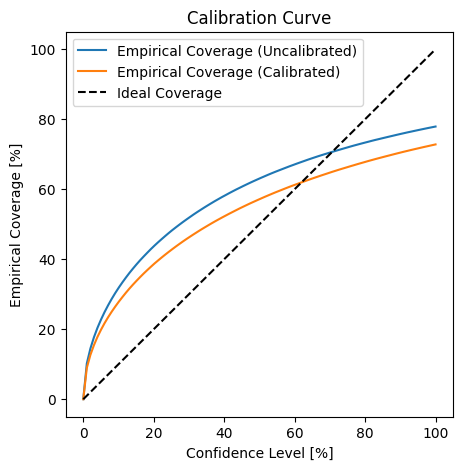

In [ ]:
confidence_levels = np.linspace(0.0, 1, 100)
coverages = np.array([np.mean(uncertainty_measurements["actual_errors_test"] <= conf * uncertainty_measurements["predicted_uncertainties_test"]) for conf in confidence_levels])
coverages_uncalibrated = np.array([np.mean(uncertainty_measurements["actual_errors_test"] <= conf * uncertainty_measurements["predicted_uncertainties_test_uncalibrated"]) for conf in confidence_levels])

plt.figure(figsize=(5, 5))
plt.plot(confidence_levels * 100, coverages_uncalibrated * 100, label='Empirical Coverage (Uncalibrated)')
plt.plot(confidence_levels * 100, coverages * 100, label='Empirical Coverage (Calibrated)')
plt.plot(confidence_levels * 100, confidence_levels * 100, 'k--', label='Ideal Coverage')
plt.xlabel('Confidence Level [%]')
plt.ylabel('Empirical Coverage [%]')
plt.title('Calibration Curve')
plt.legend()
plt.grid(False)

# save as pdf
plt.savefig(f"{filename}_calibration_curve.pdf", bbox_inches='tight', dpi=300, pad_inches=0)

# calculate the mean error in uq confidence_levels - coverages
uq_error = np.mean((confidence_levels - coverages) ** 2)
uq_error_uncalibrated = np.mean((confidence_levels - coverages_uncalibrated) ** 2)
print(f"UQ Error: {uq_error}, UQ Error (Uncalibrated): {uq_error_uncalibrated}")